In [230]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [231]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as ss
import toyplot
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])

In [241]:
# fix a random seed
np.random.seed(27)

# generate data
data = pd.DataFrame({
    "year": np.arange(1800, 2050),
    "cheeses": np.concatenate([
        np.random.poisson(3.0, 175),
        np.random.poisson(7.0, 75),
    ])
})

In [242]:
toyplot.scatterplot(
    data.year,
    data.cheeses, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N cheeses",
);

1800 1850 1900 1950 2000 2050 year 0 5 10 15 N cheeses

In [243]:
with pm.Model() as cheese_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1900)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    cheeses = pm.Poisson('cheeses', rate, observed=data.cheeses)

In [244]:
with cheese_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
100%|██████████| 10500/10500 [00:24<00:00, 426.28it/s]


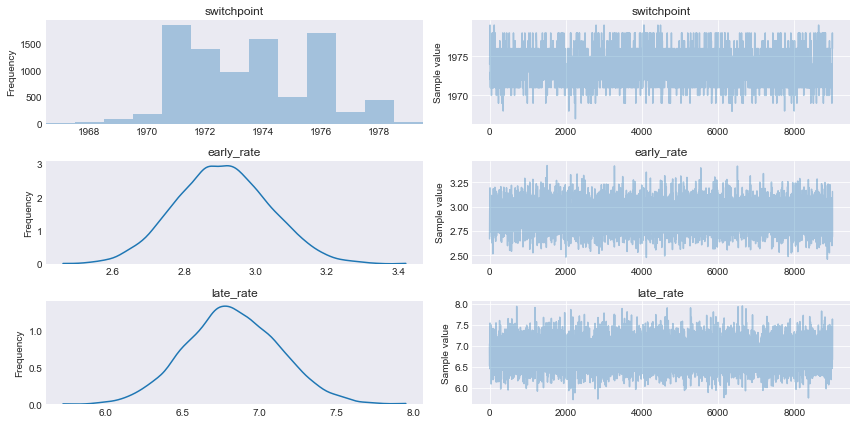

In [245]:
pm.traceplot(trace[1000:]);

In [246]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1973.505         2.226            0.062            [1971.000, 1978.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1970.000       1972.000       1973.000       1976.000       1978.000


early_rate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.906            0.130            0.001            [2.646, 3.154]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.655          2.816          2.904          2.992          3.164


late_rate:

  Mean             SD               MC Error         95% HPD interval
  -

The switch point (1975) was fairly accurately estimated. It is contained by the 95% HPD interval after running it several times.Both the early rate and late rate estimates estimate intervals are contained in their HPD intervals, although both are on the higher end of the intervals (closer to the 75th quantile). I played around with the running times for MCMC and even with much fewer iterations, the results are accurate (likely because there isn't much data) in being contained by the 95% confidence intervals although with more trials the estimates tended to be much closer to the true values. One problem I ran in to was having too small of a data set post-switch point (originally the upper bound on year was 2018), so I increased the overall size of the data set by changing the upper bound to 2050.